# 1. Data Collecting from Entso-e with API

In [1]:
from entsoe import EntsoePandasClient
import pandas as pd
import matplotlib.pyplot as plt

## Collecting energy price data

In [ ]:
from entsoe import EntsoePandasClient
import pandas as pd

# Define API key and client
api_key = '124a92a4-3770-4a39-aafd-f0a9eaf45469'
client = EntsoePandasClient(api_key=api_key)

country_code = 'NL'

def fetch_data_for_year_extended(year):
    start_date = pd.Timestamp(f'{year}-01-01 00:00', tz='Europe/Amsterdam')
    end_date = pd.Timestamp(f'{year+1}-01-01 00:00', tz='Europe/Amsterdam') 

    # Day-Ahead Prices
    print(f"Fetching day-ahead prices for {year}...")
    prices = client.query_day_ahead_prices(country_code, start=start_date, end=end_date)
    df_prices = prices.reset_index()
    df_prices.columns = ['Timestamp', 'Price']
    
    # Actual Generation
    print(f"Fetching actual generation data for {year}...")
    generation = client.query_generation(country_code, start=start_date, end=end_date)
    generation.columns = generation.columns.to_flat_index()
    df_generation = generation.reset_index()
    aggregated_cols = [col for col in df_generation.columns if isinstance(col, tuple) and col[1] == 'Actual Aggregated']
    df_generation = df_generation[['index'] + aggregated_cols]
    df_generation.rename(columns={'index': 'Timestamp'}, inplace=True)
    df_generation.columns = ['Timestamp'] + [col[0] for col in aggregated_cols]
    
    # Load Forecast (Day-Ahead)
    print(f"Fetching day-ahead load forecast for {year}...")
    load_forecast = client.query_load_forecast(country_code, start=start_date, end=end_date)
    load_forecast = load_forecast.reset_index()
    load_forecast.columns = ['Timestamp', 'Load Forecast (MW)']
    
    # Solar/Wind Forecasts (Generation Forecast)
    print(f"Fetching solar/wind generation forecasts for {year}...")
    gen_forecast = client.query_generation_forecast(country_code, start=start_date, end=end_date)
    gen_forecast = gen_forecast.reset_index()
    gen_forecast.columns = ['Timestamp'] + list(gen_forecast.columns[1:])
    
    # Merge all datasets
    print(f"Merging datasets for {year}...")
    df_merged = pd.merge(df_prices, df_generation, on='Timestamp', how='outer')
    df_merged = pd.merge(df_merged, load_forecast, on='Timestamp', how='outer')
    df_merged = pd.merge(df_merged, gen_forecast, on='Timestamp', how='outer')

    df_merged['Timestamp'] = pd.to_datetime(df_merged['Timestamp'], errors='coerce')

    # 📆 Resample naar uurlijkse data
    df_merged = df_merged.set_index('Timestamp')
    df_merged = df_merged.resample('h').mean().reset_index()

    # ➡️ Voeg uurlijkse features toe
    df_merged['Hour'] = df_merged['Timestamp'].dt.hour

    return df_merged

# 🚀 Download per jaar
df_2022 = fetch_data_for_year_extended(2022)
df_2023 = fetch_data_for_year_extended(2023)
df_2024 = fetch_data_for_year_extended(2024)

# 📚 Combineer alles
df_full = pd.concat([df_2022, df_2023, df_2024], ignore_index=True)

# 💾 Opslaan
df_full.to_csv('energy_extended_data_NL_2022_to_2024.csv', index=False)

print(f"✅ Successfully fetched and saved! Final dataset shape: {df_full.shape}")
# print(df_full.head())


Fetching day-ahead prices for 2022...
Fetching actual generation data for 2022...
Fetching day-ahead load forecast for 2022...
Fetching solar/wind generation forecasts for 2022...
Merging datasets for 2022...
Fetching day-ahead prices for 2023...
Fetching actual generation data for 2023...
Fetching day-ahead load forecast for 2023...
Fetching solar/wind generation forecasts for 2023...
Merging datasets for 2023...
Fetching day-ahead prices for 2024...
Fetching actual generation data for 2024...
Fetching day-ahead load forecast for 2024...
Fetching solar/wind generation forecasts for 2024...
Merging datasets for 2024...
✅ Successfully fetched and saved! Final dataset shape: (26307, 15)
                  Timestamp   Price  Biomass  Fossil Gas  Fossil Hard coal  \
0 2022-01-01 00:00:00+01:00  124.70    20.50     1719.25           2373.75   
1 2022-01-01 01:00:00+01:00  124.70    21.25     1828.00           2238.25   
2 2022-01-01 02:00:00+01:00  134.00    21.25     1961.50           2110.

### Collecting Weather forecast data

In [ ]:
import pandas as pd
import requests

def download_open_meteo_historical(start_date, end_date, latitude, longitude):
    base_url = 'https://archive-api.open-meteo.com/v1/archive'
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'start_date': start_date,
        'end_date': end_date,
        'hourly': (
        'temperature_2m,cloudcover,wind_speed_10m,'
        'shortwave_radiation,sunshine_duration,windgusts_10m'
         ),
        'timezone': 'Europe/Amsterdam'
    }

    response = requests.get(base_url, params=params)

    if response.status_code != 200:
        raise Exception(f"Error fetching data: {response.status_code}")

    data = response.json()

    if 'hourly' not in data:
        raise Exception("No hourly data found in response.")

    df = pd.DataFrame(data['hourly'])
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    return df

# 📍 Locatie Nederland (bijvoorbeeld Utrecht)
latitude = 52.0907
longitude = 5.1214

# 📅 Datums instellen
start_date = '2022-01-01'
end_date = '2024-12-31'

# 🚀 Download
forecast_df = download_open_meteo_historical(start_date, end_date, latitude, longitude)

# 💾 Opslaan
forecast_df.to_csv('/Users/larskinkel/Documents/UvA/Master/Thesis/ThesisData/weather_forecast_open_meteo.csv')
print(f"✅ Forecast data saved! Shape: {forecast_df.shape}")

✅ Forecast data saved! Shape: (26304, 6)


## Merging Energy price, forecasted generation, and weather forecasts data

In [17]:

# 📁 Bestandspaden (pas aan naar jouw eigen locatie)
energy_path = '/Users/larskinkel/Documents/UvA/Master/Thesis/ThesisData/energy_extended_data_NL_2022_to_2024.csv'
weather_path = '/Users/larskinkel/Documents/UvA/Master/Thesis/ThesisData/weather_forecast_open_meteo.csv'
output_path = '/Users/larskinkel/Documents/UvA/Master/Thesis/ThesisData/merged_energy_weather_2022_2024.csv'

# 📦 Data inladen
df_energy = pd.read_csv(energy_path, parse_dates=['Timestamp'])
df_weather = pd.read_csv(weather_path, parse_dates=['time'])

# 📆 Timestamps goed zetten
df_energy['Timestamp'] = pd.to_datetime(df_energy['Timestamp'], utc=True).dt.tz_convert('Europe/Amsterdam')
df_weather['time'] = pd.to_datetime(df_weather['time'], utc=True).dt.tz_convert('Europe/Amsterdam')

# 🧼 Zet tijd als index voor merge
df_energy.set_index('Timestamp', inplace=True)
df_weather.set_index('time', inplace=True)

# 🧪 Merge op timestamp
df_merged = df_energy.merge(df_weather, how='inner', left_index=True, right_index=True)

# 💾 Opslaan
df_merged.to_csv(output_path)

print(f"✅ Dataset succesvol samengevoegd en opgeslagen als:\n{output_path}")
print(f"🔎 Vorm van dataset: {df_merged.shape}")

✅ Dataset succesvol samengevoegd en opgeslagen als:
/Users/larskinkel/Documents/UvA/Master/Thesis/ThesisData/merged_energy_weather_2022_2024.csv
🔎 Vorm van dataset: (26306, 20)


# 2. Firm data on energy production and consumption

In [30]:
df_stukart2022 = pd.read_excel('/Users/larskinkel/Documents/UvA/Master/Thesis/ThesisData/Stukart2022.xls')
df_stukart2023 = pd.read_excel('/Users/larskinkel/Documents/UvA/Master/Thesis/ThesisData/Stukart2023.xls')
df_stukart2024 = pd.read_excel('/Users/larskinkel/Documents/UvA/Master/Thesis/ThesisData/Stukart2024.xls')
# Combineer de Stukart datasets
df_stukart = pd.concat([df_stukart2022, df_stukart2023, df_stukart2024], ignore_index=True)
df_stukart['Time'] = pd.to_datetime(df_stukart['Time'])
df_stukart['Production'] = df_stukart['Production']*(-1)
df_stukart = df_stukart.resample('h', on='Time').agg({
    'Bought': 'sum',
    'Sold': 'sum',
    'Demand': 'sum',
    'Production': 'sum'
}).reset_index()

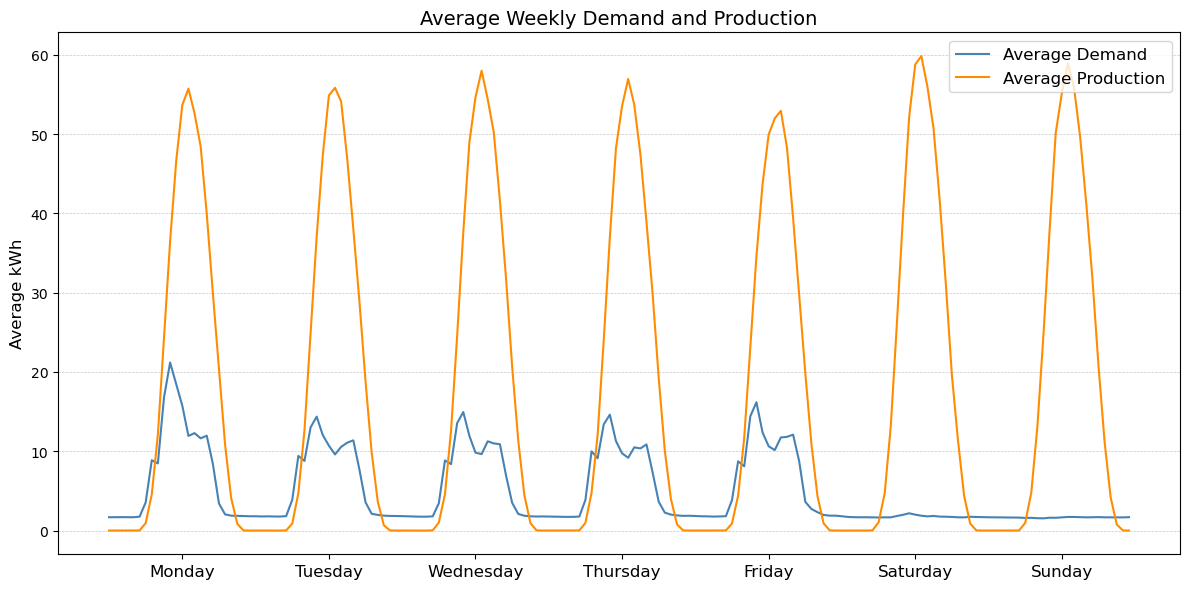

In [80]:
df_stukart['DayOfWeek'] = df_stukart['Time'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df_stukart['Hour'] = df_stukart['Time'].dt.hour

# Group by day of the week and hour, then calculate the average demand and production
average_week = df_stukart.groupby(['DayOfWeek', 'Hour']).mean().reset_index()

# Map day names for the x-axis
day_labels = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

plt.figure(figsize=(12, 6))
plt.plot(average_week['DayOfWeek'] + average_week['Hour'] / 24, average_week['Demand'], label='Average Demand', color='steelblue', linewidth=1.5)
plt.plot(average_week['DayOfWeek'] + average_week['Hour'] / 24, average_week['Production'], label='Average Production', color='darkorange', linewidth=1.5)

# Set x-axis labels to show only the days
plt.xticks(ticks=[i + 0.5 for i in range(7)], labels=[day_labels[i] for i in range(7)], fontsize=12)
plt.ylabel('Average kWh', fontsize=12)
plt.title('Average Weekly Demand and Production', fontsize=14)
plt.legend(fontsize=12, loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

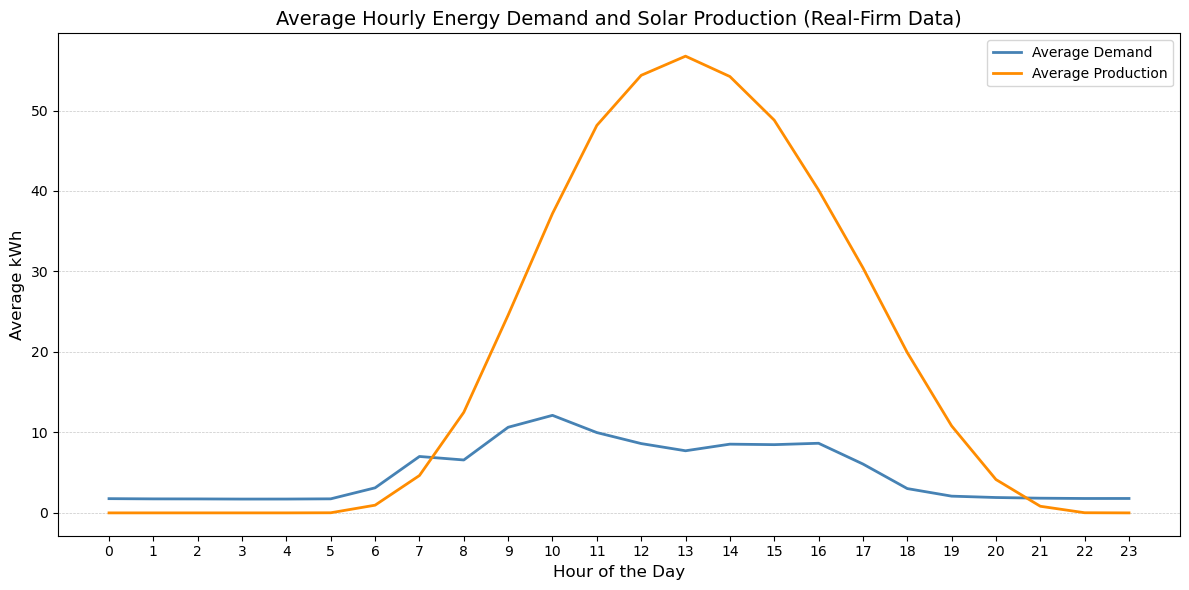

In [ ]:
average_day = df_stukart.groupby('Hour').mean().reset_index()

x = average_day['Hour']
y1 = average_day['Demand']
y2 = average_day['Production']

plt.figure(figsize=(12, 6))

plt.plot(x, y1, label='Average Demand', color='steelblue', linewidth=2)
plt.plot(x, y2, label='Average Production', color='darkorange', linewidth=2)

plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Average kWh', fontsize=12)

plt.title("Average Hourly Energy Demand and Solar Production (Real-Firm Data)", fontsize=14)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=10, frameon=True)
plt.xticks(range(0, 24), fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()